In [1]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [2]:
import glob
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load ext files and paths

In [4]:
pattern_path_base = 'test/daegeum/'
pattern_path_sub = ['pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

# print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

pitch_paths = pattern_paths['pitches']

['nam_d', 'hwang_u', 'nam_u', 'joong', 'tae_u', 'joong_dd', 'lim_d', 'tae', 'go_d', 'mu', 'joong_u', 'hwang_dd', 'hyeop_u', 'go', 'hwang_d', 'mu_d', 'tae_d', 'nam', 'mu_u', 'tae_dd', 'lim_dd', 'lim_u', 'lim', 'nam_dd', 'hwang_uu', 'hwang', 'hwang_ot', 'joong_d', 'hyeop']


# pre-process pattern imgs

## test: removing background

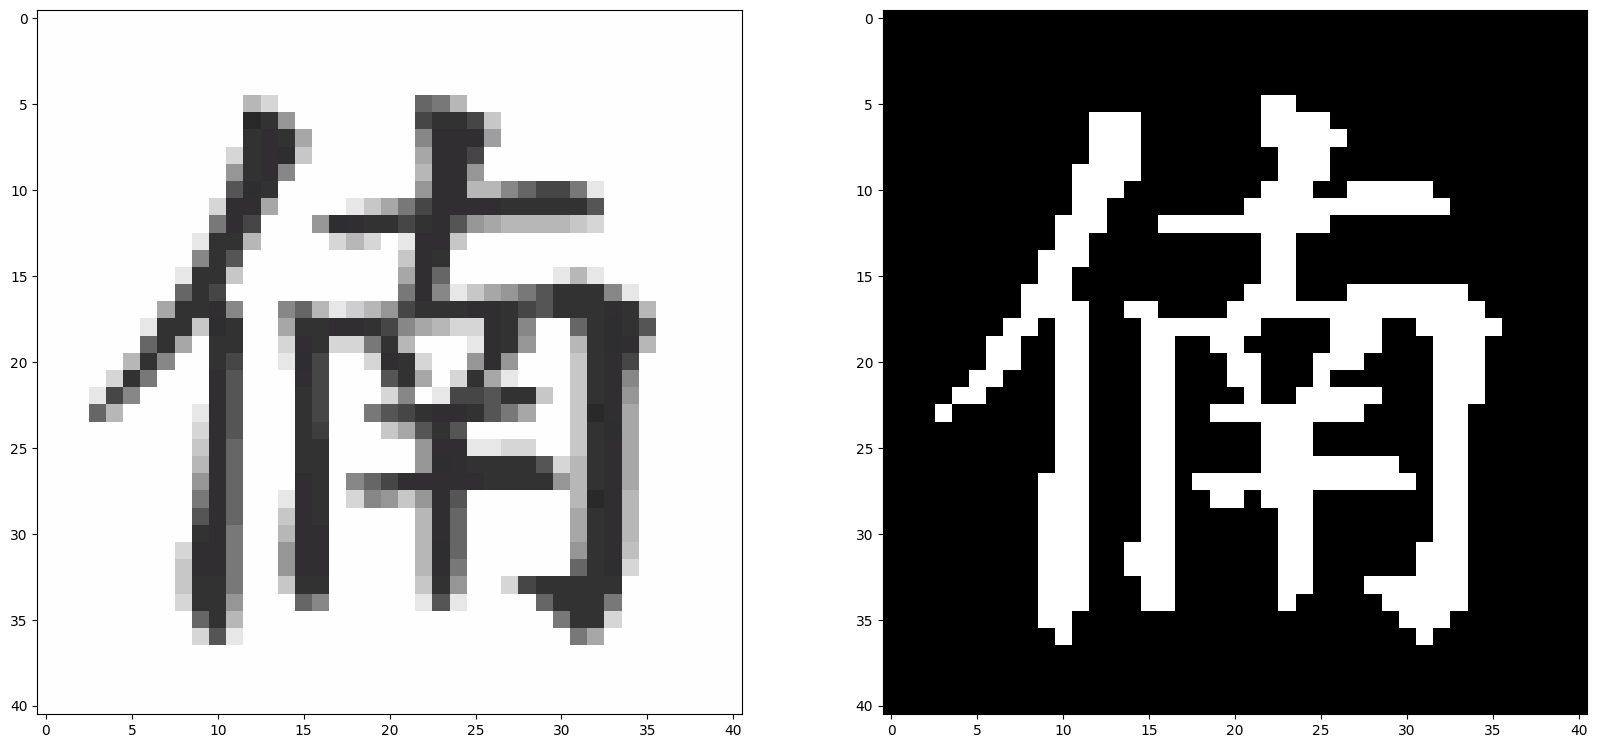

In [4]:
nam_d = cv2.imread(pitch_paths['nam_d']).copy()
nam_d = cv2.cvtColor(nam_d, cv2.COLOR_RGB2RGBA)

nam_d_grey = cv2.cvtColor(nam_d, cv2.COLOR_RGBA2GRAY)
nam_d_thresh = cv2.threshold(nam_d_grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(nam_d)

plt.subplot(1, 2, 2)
plt.imshow(nam_d_thresh, cmap=('gray'))

plt.show()

## remove background from all pitch char imgs (Done)

In [42]:
def remove_background(img, crop=True):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  
  img_grey = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
  img_thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  
  y, x = np.where(img_thresh < 1)
  
  img_cp = img.copy()
  
  img_cp[y, x] = np.full(4, 0, dtype=np.uint8)
  
  if not crop:
    return img_cp
  
  slice_idxs = []
  
  for iter_num in range(4):
    target = np.transpose(img_cp, axes=(1, 0, 2)) if iter_num > 1 else img_cp
      
    rng = range(len(target)) if iter_num % 2 == 0 else range(len(target) - 1, 0, -1)
    
    for idx in rng:
      arr = target[idx]
      op_sum = sum(arr[:, 3])
      
      if op_sum > 0:
        slice_idxs.append(idx)
        break
  
  row_st, row_ed, col_st, col_ed = slice_idxs
  
  return img_cp[row_st:row_ed+1, col_st:col_ed+1, :]

for pname, path in pitch_paths.items():
  img = cv2.imread(path)
  img_wo_bg = remove_background(img)
  
  cv2.imwrite(f'test/synth/src/pitches/{pname}.png', img_wo_bg)

## char img example

tae_u


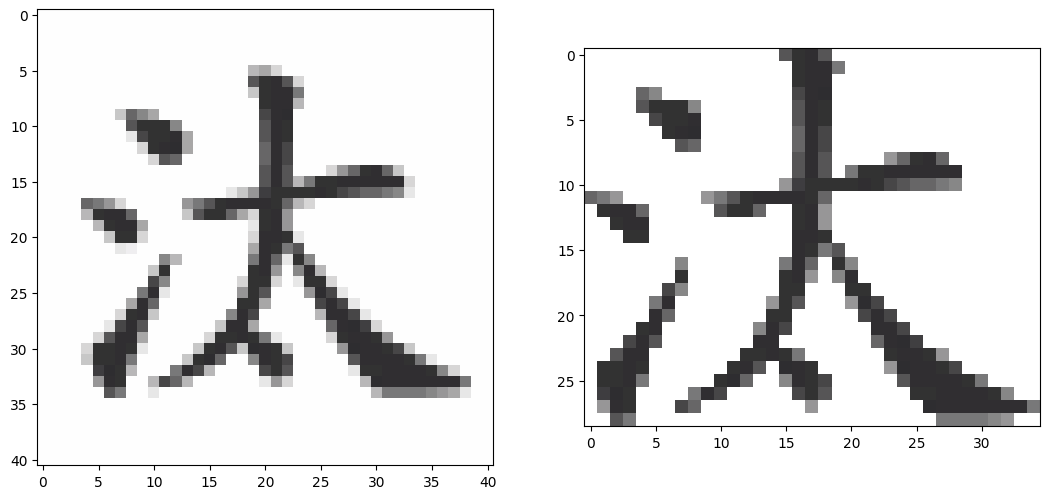

In [146]:
idx = 28
char = sorted([ name for name in pattern_paths['pitches'].keys() ])[idx]
og = cv2.imread(f'test/daegeum/pitches/{char}.png')
mod = cv2.imread(f'test/synth/src/pitches/{char}.png', cv2.IMREAD_UNCHANGED)

print(char)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(og)

plt.subplot(1, 3, 2)
plt.imshow(mod)

plt.show()

# Jng sizes

In [6]:
jng_img_dir = 'test/split_pngs'
jng_img_paths = sorted(glob.glob(f'{jng_img_dir}/*.png'))

width = []
height = []

for path in tqdm(jng_img_paths, leave=False):
  h, w, _ = cv2.imread(path).shape
  width.append(w)
  height.append(h)

ratio = [ round(h/w, 1) for w, h in zip(width, height)]

## Jng ratio histogram

<BarContainer object of 15 artists>

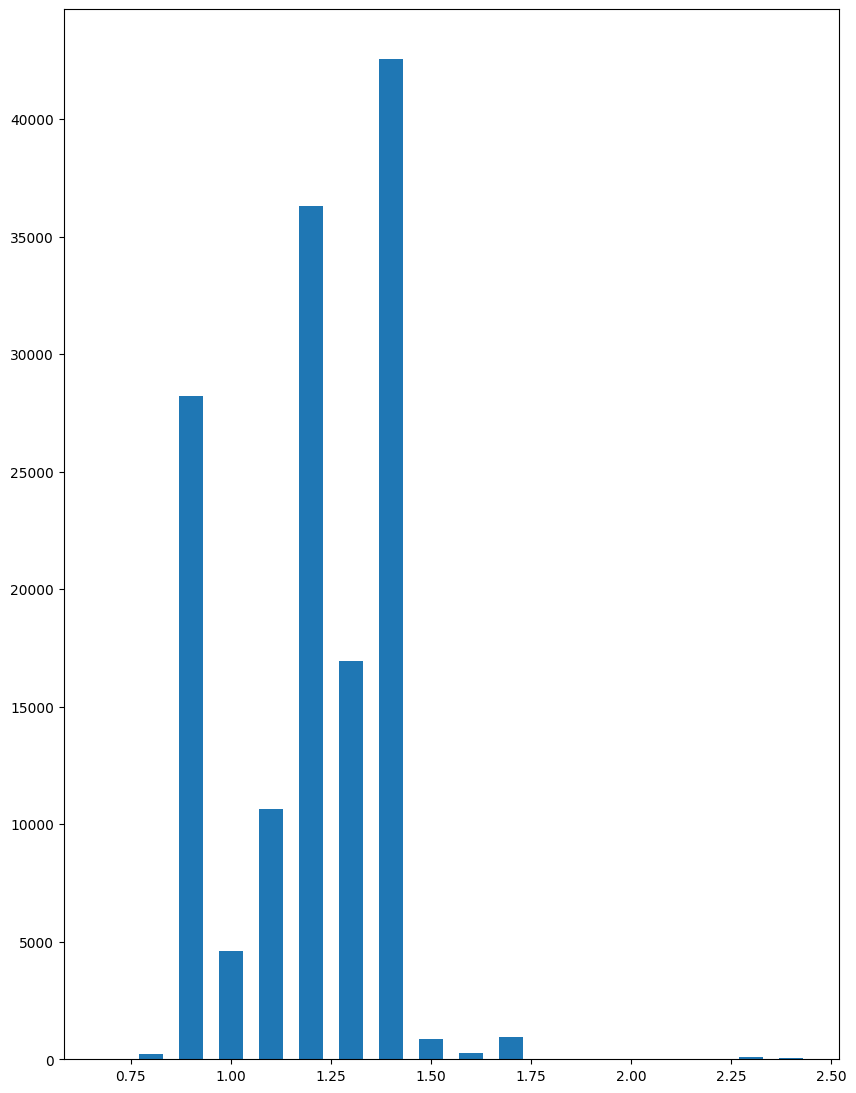

In [8]:
from collections import Counter

ratios = (ratio)
widths = Counter(width)

plt.figure(figsize=(10, 30))

plt.subplot(2, 1, 1)
plt.bar(ratios.keys(), ratios.values(), 0.06)

In [10]:
ratio_tups = [ (r, c) for r, c in ratios.items() ]

ratio_tups.sort(key = lambda x: x[0], reverse=True)

ratio_tups

[(2.4, 46),
 (2.3, 95),
 (2.2, 11),
 (1.8, 8),
 (1.7, 945),
 (1.6, 268),
 (1.5, 852),
 (1.4, 42542),
 (1.3, 16963),
 (1.2, 36281),
 (1.1, 10659),
 (1.0, 4627),
 (0.9, 28200),
 (0.8, 224),
 (0.7, 17)]

## Jng width histogram

<BarContainer object of 18 artists>

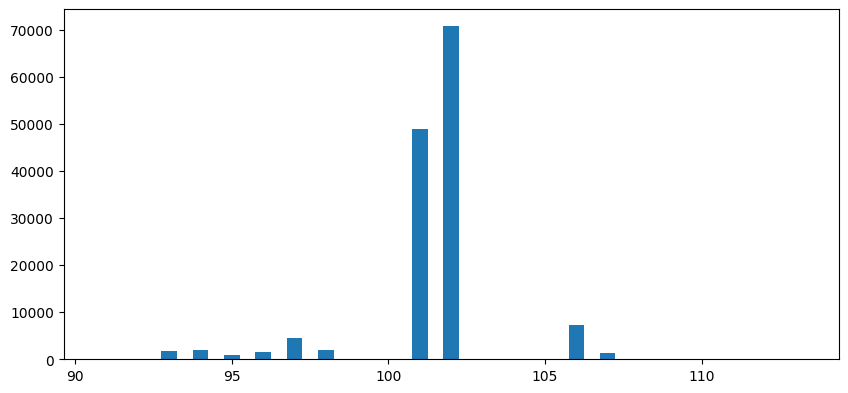

In [9]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.bar(widths.keys(), widths.values(), 0.5)

In [27]:
width_tups = [ (w, c) for w, c, in widths.items() ]
width_tups.sort(key=lambda x: x[0], reverse=True)

width_tups, sum([ w for w, _ in width_tups])/len(width_tups)

([(113, 24),
  (112, 48),
  (107, 1361),
  (106, 7332),
  (105, 59),
  (104, 125),
  (103, 96),
  (102, 70787),
  (101, 49007),
  (100, 102),
  (99, 11),
  (98, 2034),
  (97, 4464),
  (96, 1546),
  (95, 941),
  (94, 1989),
  (93, 1680),
  (91, 132)],
 100.88888888888889)

# Jng Synthesizer

## PATHS

In [3]:
pattern_path_base = 'test/synth/src/'
pattern_path_sub = ['pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

# print([ name for name in pattern_paths['notations'].keys() ])
print(sorted([ name for name in pattern_paths['pitches'].keys() ]))

pitch_paths = pattern_paths['pitches']

['go', 'go_d', 'hwang', 'hwang_d', 'hwang_dd', 'hwang_ot', 'hwang_u', 'hwang_uu', 'hwnag_d', 'hyeop', 'hyeop_u', 'joong', 'joong_d', 'joong_dd', 'joong_u', 'lim', 'lim_d', 'lim_dd', 'lim_u', 'mu', 'mu_d', 'mu_u', 'nam', 'nam_d', 'nam_dd', 'nam_u', 'tae', 'tae_d', 'tae_dd', 'tae_u']


## CONSTS

**memo**

* width
    * init width: 100
    * width noise: -10 ~ 13

* ratio
    * init ratio: 1.4
    * ratio noise: -0.7 ~ 1.0

In [4]:
INIT_WIDTH = 100
WIDTH_NOISE_SIG = 3.34
WIDTH_NOISE_MIN = -10
WIDTH_NOISE_MAX = 13

INIT_RATIO = 1.4
RATIO_NOISE_SIG = 0.3
RATIO_NOISE_MIN = -0.7
RATIO_NOISE_MAX = 1.0

# pitch order: 황, 대, 태, 협, 고, 중, 유, 임, 이, 남, 무, 응
# PITCH_ORDER = ['hwang', 'dae', 'tae', 'hyeop', 'go', 'joong', 'yoo', 'lim', 'ee', 'nam', 'mu', 'eung']
OCTAVE_WIDTH = 8
OCTAVE_RANGE = 5

PITCH_ORDER = [
  'hwang_dd', 'tae_dd',  None,        None,   'joong_dd', 'lim_dd', 'nam_dd',    None,
  'hwang_d',  'tae_d',   None,       'go_d',  'joong_d',  'lim_d',  'nam_d',    'mu_d',
  'hwang',    'tae',    'hyeop',     'go',    'joong',    'lim',    'nam',      'mu',
  'hwang_u',  'tae_u',  'hyeop_u',    None,   'joong_u',  'lim_u',  'nam_u',    'mu_u',
  'hwang_uu'
]

## label

In [5]:
from random import randint, choice

def get_pitch_range(): # len 5 ~ 8
  num_pitch = len(PITCH_ORDER)
  
  center = randint(0, num_pitch)
  offset = bool(randint(0, 1)) # True: center is 3rd / False: center is 4th
  
  min_idx = 3 if offset else 4
  max_idx = 5 if offset else 4
  
  res = []
  
  if center < min_idx:
    res = PITCH_ORDER[:OCTAVE_WIDTH]
    
  elif center > num_pitch - max_idx:
    res = PITCH_ORDER[num_pitch-OCTAVE_WIDTH:]
  
  else:
    res = PITCH_ORDER[center-min_idx:center+max_idx]
  
  return list(filter(None, res))

def get_jng_dict(plist, div=None):
  row_div = div if div else randint(1, 3)
  
  res = {
    'row_div': row_div,
    'rows': []
  }
  
  prev = ''
  
  for _ in range(row_div):
    col_div = randint(1, 2) if row_div > 1 else 1
    cols = []
    
    for _ in range(col_div):
      cur = choice(plist)
      
      if (cur == prev and prev != 'conti'):
        cols.append('conti')
      
      else:
        if randint(1, 6) > 7 and prev != 'conti':
          cols.appned('conti')
        else:
          cols.append(cur)
        
        prev = cur
    
    res['rows'].append({
      'col_div': col_div,
      'cols': cols
    })
  
  return res

print(get_pitch_range())
print(get_jng_dict(get_pitch_range()))

['tae_u', 'hyeop_u', 'joong_u', 'lim_u', 'nam_u', 'mu_u', 'hwang_uu']
{'row_div': 2, 'rows': [{'col_div': 2, 'cols': ['hyeop', 'mu_d']}, {'col_div': 1, 'cols': ['tae']}]}


## image

### exp: size random noise 

widths:  [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
ratios:  [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]


<BarContainer object of 18 artists>

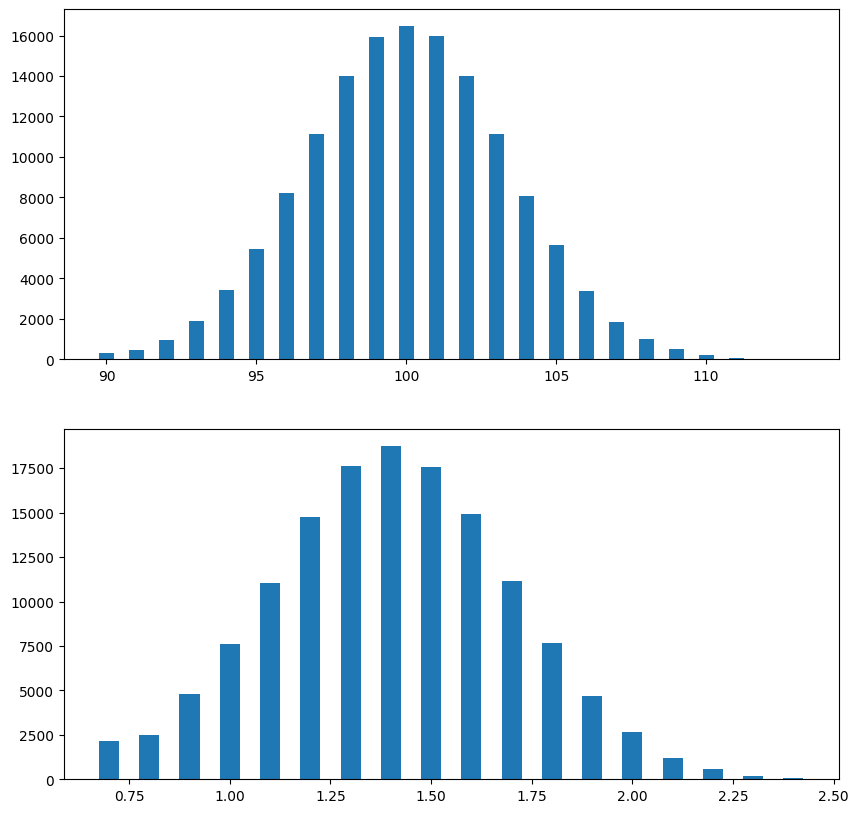

In [9]:
from collections import Counter

random_widths = Counter(map(lambda x: INIT_WIDTH + round(min(WIDTH_NOISE_MAX, max(WIDTH_NOISE_MIN, x))), np.random.normal(0, WIDTH_NOISE_SIG, 140000).tolist()))

random_ratios = Counter(
  map(
    lambda x: round(INIT_RATIO + min(RATIO_NOISE_MAX, max(RATIO_NOISE_MIN, x)), 1), 
    np.random.normal(0, RATIO_NOISE_SIG, 140000).tolist()
  )
)

print('widths: ', sorted(random_widths))
print('ratios: ', sorted(random_ratios))


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, (1, 2))
plt.bar(random_widths.keys(), random_widths.values(), 0.5)

plt.subplot(2, 2, (3, 4))
plt.bar(random_ratios.keys(), random_ratios.values(), 0.05)

### get_size()

In [6]:
def clamp(val, _min, _max):
  return min(_max, max(_min, val))

def get_width():
  noise = clamp( round(np.random.normal(0, WIDTH_NOISE_SIG)), WIDTH_NOISE_MIN, WIDTH_NOISE_MAX )
  return INIT_WIDTH + noise

def get_ratio(): 
  noise = round( clamp( np.random.normal(0, RATIO_NOISE_SIG), RATIO_NOISE_MIN, RATIO_NOISE_MAX ), 1 )
  return INIT_RATIO + noise 

def get_size():
  width = get_width()
  ratio = get_ratio()
  
  return width, round(width * ratio)

get_size()

(97, 146)

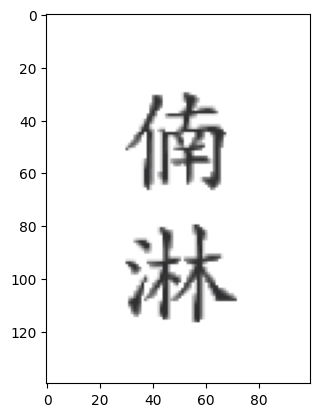

In [7]:
def get_blank(width, height, bg='white'):
  blank = np.zeros((height, width, 4), dtype=np.uint8)
  
  if bg == 'white':
    blank[:, :] = np.array([255, 255, 255, 255], dtype=np.uint8)
  elif bg == 'black':
    blank[:, :] = np.array([0, 0, 0, 255], dtype=np.uint8)
  
  return blank

def insert_img(src, insert, x, y):
  h, w = insert.shape[:2]

  # normalize alpha to 0 ~ 1
  src_alpha = src[y:y+h, x:x+w, 3] / 255.0
  ins_alpha = insert[:, :, 3] / 255.0

  # blend src and insert channel by channel
  for ch in range(0, 3):
    src[y:y+h, x:x+w, ch] = ins_alpha * insert[:, :, ch] + \
                            src_alpha * src[y:y+h, x:x+w, ch] * (1 - ins_alpha)

  # denoramlize alpha to 0 ~ 255
  src[y:y+h, x:x+w, 3] = (1 - (1 - ins_alpha) * (1 - src_alpha)) * 255
  
  return src

def resize_img_by_height(img, target_height):
  og_h, og_w = img.shape[:2]
  
  resize_ratio = target_height / og_h
  resize_width = round(og_w * resize_ratio)
  
  return cv2.resize(img, dsize=(resize_width, target_height), interpolation=cv2.INTER_AREA)

insert_paths = [pitch_paths['nam_d'], pitch_paths['lim_u']]
positions = [ (30, 30), (30, 80) ]

img = get_blank(100, 140)

target_height = 37

for idx, ins_path in enumerate(insert_paths):
  ins = cv2.imread(ins_path, cv2.IMREAD_UNCHANGED)
  
  ins_re = resize_img_by_height(ins, target_height)
  
  ins_x, ins_y = positions[idx]
  
  img = insert_img(img, ins_re, ins_x, ins_y)

plt.imshow(img)

In [8]:
def make_conti(width, height):
  img = cv2.imread('test/synth/src/notations/conti.png', cv2.IMREAD_UNCHANGED)
  
  img = cv2.resize(img, dsize=(width, img.shape[0]))
  
  bg = get_blank(width, height)
  bg[:, :, 3] = 0
  
  return insert_img(bg, img, 0, height//2 - 1)

make_conti(21, 27).shape

(27, 21, 4)

In [2]:
from exp_utils import JeongganProcessor

img_w, img_h = get_size()
img = get_blank(img_w, img_h, img_h/img_w)

pitch_range = get_pitch_range()
jng_dict = get_jng_dict( pitch_range, div=( 2 if img_h/img_w < 1.0 else None ) )

# print(img_w, img_h)
# print(jng_dict)

row_div = jng_dict['row_div']

note_height = 47 if row_div == 1 else 40
conti_height = 27

row_heights = []
for row in jng_dict['rows']:
  if row['col_div'] == 1 and row['cols'][0] == 'conti':
    row_heights.append(conti_height)
    continue
  
  row_heights.append(note_height)

gap = (img_h - sum(row_heights)) // (row_div + 1)

row_template = [ gap + idx * (row_heights[idx - 1 if idx > 0 else idx] + gap) for idx in range(row_div) ]

for row_idx, row in enumerate(jng_dict['rows']):
  col_div = row['col_div']
  
  notes = [] 
  for note_name in row['cols']:
    note = cv2.imread(pitch_paths[note_name], cv2.IMREAD_UNCHANGED) if note_name != 'conti' else make_conti(21, conti_height)
    note = resize_img_by_height(note, note_height) if note_name != 'conti' else note
    
    notes.append((note, note_name))
  
  # print([ (note.shape, note_name) for note, note_name in notes])
  
  gap = ( img_w - sum( [ note[0].shape[1] for note in notes ] ) ) // (col_div + 1)
  col_template = [ gap + idx * (notes[idx - 1 if idx > 0 else idx][0].shape[1] + gap) for idx in range(col_div) ] if col_div > 1 else [ round(img_w / 2) - round(notes[0][0].shape[1] / 2) ]
  
  for col_idx, note_tuple in enumerate(notes):
    note, note_name = note_tuple
    
    pos_x = col_template[col_idx]
    pos_y = row_template[row_idx]
    
    if note_name == 'conti':
      pos_y += (note_height - note.shape[0]) // 2
  
    img = insert_img(img, note, pos_x, pos_y)

jng_dict_format = {
  'row_div': jng_dict['row_div'],
  'rows': [ { 'col_div': row['col_div'], 'cols': [ (0, 0, 0, 0, col) for col in row['cols'] ]} for row in jng_dict['rows'] ]
}

print(JeongganProcessor.get_label( jng_dict_format ))
plt.imshow(img)

ModuleNotFoundError: No module named 'exp_utils'